<a href="https://colab.research.google.com/github/Nathalia-Prada/proyecto-integrador-equipo25/blob/main/Avance5Equipo25%20/Avance5Equipo25_forecast2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Avance 5. Modelo final Series de Tiempo: Forecasting con XGBoost**

3.5 Mejorar significativamente el rendimiento al aprovechar las fortalezas de diferentes modelos y reducir sus debilidades.

3.6 Evaluar la calidad de las predicciones del modelo en datos no vistos.


###**Equipo 25**


### Estudiantes


* A01793899 - Andrés Julián López Hurtado
* A01793999 - Nathalia Milena Prada Hernández
* A01794404 - Victor Alejandro Regueira Romero

Fecha: 27 de octubre de 2024

# Instrucciones
En esta etapa se busca crear una variedad de modelos de ensamble para solucionar el problema planteado. Para ello, deberán tomar en cuenta las siguientes consideraciones:
Incluir la optimización de hiperparámetros para los modelos más relevantes.
Utilizar algoritmos que apliquen tanto estrategias de ensamble homogéneas como heterogéneas.
Para las estrategias de stacking y/o blending, se deberán emplear los modelos individuales de mejor rendimiento obtenidos en la fase anterior.


Una vez que se han generado los modelos de ensamble, sintetizar los resultados en una tabla comparativa en la que se incluyan los modelos individuales de la fase previa.



Los modelos deben ser ordenados por la métrica principal, pero el resumen debe incorporar otras métricas pertinentes.
Se deberán incluir también los tiempos de entrenamiento.
Se elige el modelo final alineado con los objetivos y necesidades del negocio.



Del modelo elegido, generar algunos gráficos significativos con su interpretación. La siguiente lista proporciona ejemplos, pero no es exhaustiva:
- Curva ROC
- Matriz de confusión
- Curva de Precisión-Recall
- Análisis de residuos
- Gráfico de importancia de características
- Tendencia y predicción (para series temporales)
- Diagrama de árbol (para árboles de decisión)

# Importar Drive


In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Librerías


Se inicia importando las librerías y leyendo el dataset.

In [57]:
!pip install optuna

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Rutas de archivos y carga de la base

In [59]:
file_tabla_unida = '/content/drive/MyDrive/TECForza/df_union2.csv'
#file_tabla_unida = '/content/drive/MyDrive/0-Actual/MNA/proyecto_integrador/df_union2.csv'

In [60]:
df_tabla_unida = pd.read_csv(file_tabla_unida)
df_tabla_unida.head()

,name,date,total_distance_used_sum,total_fuel_used_sum,consumption,performance,distance,idlingDuration,idlingPercent,idlingDuration_hours,...,ExcessiveSpeedingCount,ExcessiveSpeedingDistance,HardAccelerationCount,HardAccelerationDistance,HarshBrakingCount,HarshBrakingDistance,HarshCorneringDuration,HarshCorneringCount,HarshCorneringDistance,MaxSpeed
0,986,2024-07-01,115.575006,15.321976,7.543088,0.132572,30.063228,08:12:02,87.0,8.20,...,159.0,50.848373,133.0,0.057267,1.0,0.000096,0.0,43.0,0.006195,83.885109
1,1038,2024-07-01,167.770170,25.096340,6.685045,0.149588,72.647624,06:53:43,62.0,6.90,...,19.0,2.382248,17.0,0.002865,0.0,0.000000,0.0,28.0,0.002594,76.428658
2,502,2024-07-02,1025.262150,68.948892,8.653096,0.067250,912.121800,11:00:31,46.0,11.01,...,105.5,38.452164,48.0,0.020623,0.5,0.000332,0.0,39.5,0.009367,42.874611
3,532,2024-07-02,1103.554896,75.817364,14.555437,0.068703,554.235964,01:34:01,14.0,1.57,...,3.5,0.055369,77.5,0.065764,0.0,0.000000,0.0,18.5,0.007460,38.835701
4,880,2024-07-02,857.491980,64.193796,13.357864,0.074862,429.840038,20:46:51,73.0,20.78,...,402.0,123.554245,59.0,0.020675,0.0,0.000000,0.0,37.0,0.020335,83.885109


# Variables seleccionadas y datasets

In [61]:
df_tabla_unida.columns

Index(['name', 'date', 'total_distance_used_sum', 'total_fuel_used_sum',
       'consumption', 'performance', 'distance', 'idlingDuration',
       'idlingPercent', 'idlingDuration_hours', 'CurrentFuelPrice',
       'IdlingCost', 'SpeedLimit1Count', 'SpeedLimit2Count',
       'SpeedLimit3Count', 'TotalDrivingDuration', 'AverageSpeed',
       'StopUnder10Count', 'StopOver10Count', 'StopOver20Count',
       'StopOver30Count', 'StopOver40Count', 'StopOver50Count',
       'IdlingOver5Count', 'IdlingDuration', 'AfterHoursTripCount',
       'TotalDistance', 'TotalStopsCount', 'SpeedingDuration', 'SpeedingCount',
       'SpeedingDistance', 'ExcessiveSpeedingDuration',
       'ExcessiveSpeedingCount', 'ExcessiveSpeedingDistance',
       'HardAccelerationCount', 'HardAccelerationDistance',
       'HarshBrakingCount', 'HarshBrakingDistance', 'HarshCorneringDuration',
       'HarshCorneringCount', 'HarshCorneringDistance', 'MaxSpeed'],
      dtype='object')

In [62]:
selected_columns = ['date', 'consumption']
df = df_tabla_unida[selected_columns]

Para el análisis de series de tiempo, se necesitan únicamente el consumo y la fecha del viaje, en este caso, las columnas `consumption` y `date`, respectivamente. Se asignará la columna `date` al índice del dataframe; sin embargo, antes debe convertirse de tipo *object* a *datetime* utilizando el método `to_datetime` de la librería Pandas. Finalmente, se muestra el consumo en una frecuencia de acumulado diario.

In [63]:
#convertir a datetime
df['date'] = pd.to_datetime(df['date'])
df_fc = df.set_index('date')

<ipython-input-63-6668be612607>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


In [64]:
#crear acumulado diario
count_date = df_fc.groupby(df_fc.index.date)['consumption'].sum()
fc_clean = pd.DataFrame(count_date)
fc_clean['date'] = pd.to_datetime(fc_clean.index)
fc_clean = fc_clean.set_index('date')

In [65]:
fc_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 2024-07-01 to 2024-08-31
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   consumption  61 non-null     float64
dtypes: float64(1)
memory usage: 976.0 bytes


El primer paso en cualquier análisis de series de tiempo es graficar los datos. La visualización permite detectar patrones, lecturas atípicas, variaciones en el tiempo y la relación entre variables.

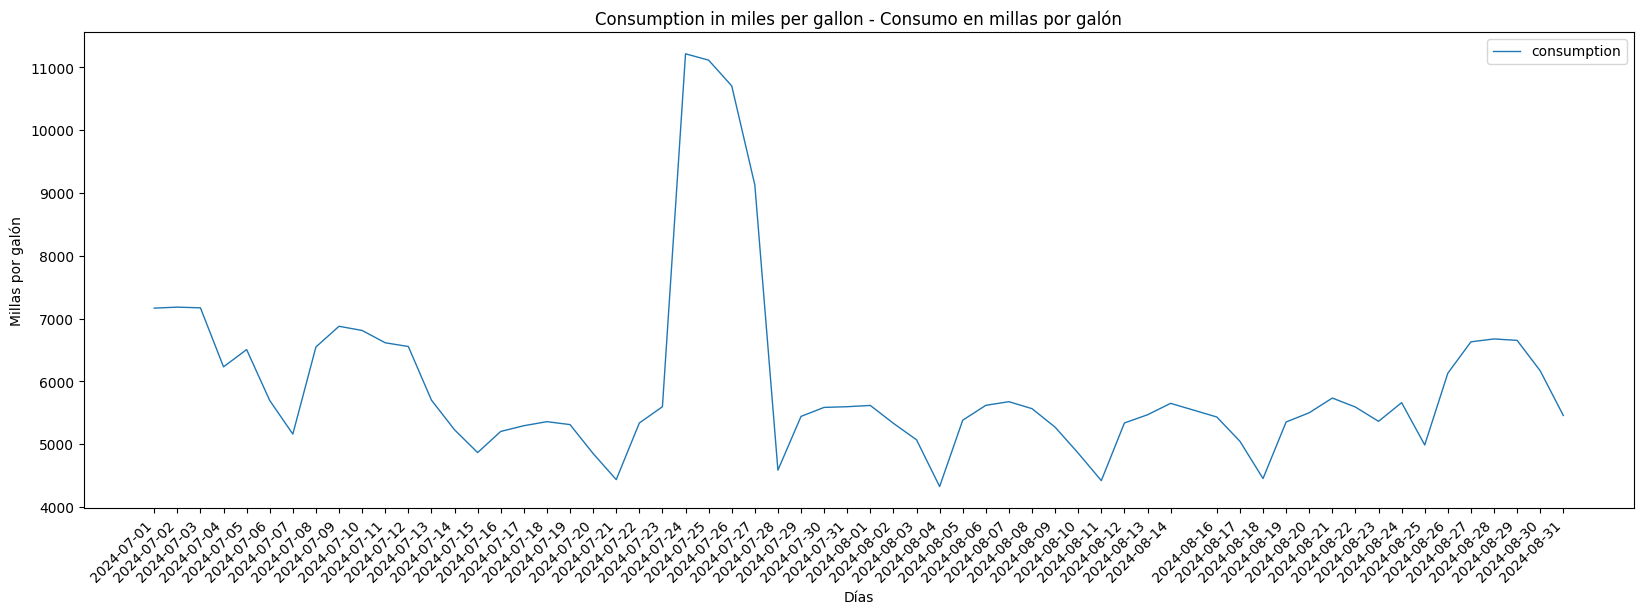

In [66]:
fc_clean.plot(style='-', figsize=(20, 7), lw=1, title='Consumption in miles per gallon - Consumo en millas por galón')

# Establecer la frecuencia de etiquetas del eje x para mostrar todos los días
plt.xticks(fc_clean.index, rotation=45)  # Rotación opcional para mejorar la visibilidad
plt.xlabel('Días')
plt.ylabel('Millas por galón')

plt.show()

# 1. Tendencias Generales
- **Disminución Inicial**: Desde el 1 de julio hasta el 8 de julio, se observa una ligera tendencia a la baja en el consumo, cayendo de aproximadamente 7166 a 5161.
- **Aumento Moderado**: Entre el 8 y el 15 de julio, el consumo muestra un aumento gradual, alcanzando un máximo de 6615 el 11 de julio.
- **Fluctuaciones a partir de la Segunda Quincena de Julio**: Desde el 15 de julio, el consumo comienza a fluctuar significativamente, con un notable aumento hacia el final del mes.

# 2. Picos de Consumo
- **Picos Notables**: Se identifican picos significativos en:
  - 24 de julio: 11,215.996 (consumo excepcionalmente alto).
  - 25 de julio: 11,114.945 (otro día de consumo muy alto).
  
  Estos dos días se destacan como anomalías en comparación con el resto del mes.

# 3. Tendencias en Agosto
- **Recuperación de Consumo**: Tras los picos de julio, el consumo desciende a valores más bajos en los primeros días de agosto, pero mantiene una tendencia moderadamente estable con ligeros picos y caídas.
- **Consumo en la Mitad de Agosto**: Hacia mediados de agosto, se observan incrementos progresivos, especialmente alrededor del 19 y 20 de agosto.
- **Fluctuaciones a Finales de Agosto**: Al final de agosto, el consumo muestra una variabilidad, pero en general se mantiene dentro de un rango similar al de principios de mes.

# Conclusiones
- **Picos en Consumo**: Los días 24 y 25 de julio muestran consumos extraordinarios, lo que podría indicar algún evento o actividad especial.
- **Tendencia a la Baja Inicial**: Después de los picos, el consumo disminuye, pero se observa cierta recuperación y variabilidad en agosto.
- **Consumo Generalmente Estable**: A pesar de las fluctuaciones, el consumo se mantiene en un rango relativamente constante a lo largo de agosto, con algunos picos y valles menores.

# Modelo XGBoost

XGBoost (Extreme Gradient Boosting) es una implementación avanzada del algoritmo Gradient Boosting (GBM) para tareas de aprendizaje supervisado, como regresión y clasificación. Este algoritmo utiliza ensambles de árboles de decisión (Tree Ensembles) para combinar múltiples modelos "débiles" y producir un modelo predictivo de mayor precisión. XGBoost aplica la técnica de boosting como método de ensamble y utiliza descenso de gradiente para optimizar el proceso, brindando gran flexibilidad en el ajuste de hiperparámetros para controlar la complejidad y mitigar el sobreentrenamiento (overfitting). También soporta el tratamiento de valores faltantes y variables categóricas.

Para este análisis, solo se ajustarán los siguientes hiperparámetros:

- **booster**: Tipo de modelo utilizado; por defecto, `gbtree`, que emplea árboles de decisión.
- **n_estimators**: Número de modelos en el ensamble. Un valor bajo puede causar underfitting, mientras que uno muy alto puede llevar al sobreentrenamiento.
- **early_stopping_rounds**: Número de iteraciones tras el cual se detiene automáticamente el entrenamiento si no mejora el score de validación. Este parámetro suele utilizarse con un valor alto de `n_estimators`, permitiendo que `early_stopping_rounds` determine el número óptimo de iteraciones.
- **objective**: Define la tarea de aprendizaje y el objetivo de optimización. En este caso, se especifica `'reg:squarederror'` para regresión con error cuadrático.
- **reg_lambda**: Parámetro de regularización, equivalente a Ridge (L2) en regresiones múltiples, que penaliza de forma uniforme todos los pesos del modelo. Un valor más alto hace el modelo más conservador.
- **max_depth**: Profundidad máxima de los árboles de decisión. Una mayor profundidad puede mejorar el ajuste, pero incrementa el riesgo de sobreentrenamiento.
- **eta**: Tasa de aprendizaje en cada iteración. Un valor mayor permite una convergencia más rápida, aunque podría "saltar" el valor óptimo; un valor menor ofrece un ajuste más gradual, aunque puede no alcanzar el mínimo de la función objetivo.

## Creación de Atributos (feature engineering)

De momento, el dataset solo contiene la variable de salida ('Consumption in miles per gallon - Consumo en millas por galón).

El siguiente paso consiste en agregar características que ayuden a explicar el comportamiento de esta variable. Para ello, se aprovechan los métodos de la librería Pandas para manipular datos de tipo `datetime`. Se define una función para crear variables adicionales basadas en el índice de la serie de tiempo:

In [67]:
def create_attributes(df):
    df = df.copy()
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

fc_clean = create_attributes(fc_clean)
fc_clean

,consumption,day,dayofweek,month,quarter,year,dayofyear
date,,,,,,,
2024-07-01,7166.415676,1,0,7,3,2024,183
2024-07-02,7182.232302,2,1,7,3,2024,184
2024-07-03,7171.074568,3,2,7,3,2024,185
2024-07-04,6231.688432,4,3,7,3,2024,186
2024-07-05,6506.612911,5,4,7,3,2024,187
...,...,...,...,...,...,...,...
2024-08-27,6630.083851,27,1,8,3,2024,240
2024-08-28,6675.791509,28,2,8,3,2024,241
2024-08-29,6653.025786,29,3,8,3,2024,242


### Entrenando el Modelo

Antes del entrenamiento, se divide el conjunto de datos en un set de prueba y otro de validación. Es importante recordar que, en el caso de series de tiempo, no es adecuado realizar una división aleatoria para la validación cruzada (cross-validation), debido a la correlación entre observaciones cercanas en el tiempo.

Para abordar esto, se utiliza la clase `TimeSeriesSplit` de la librería Scikit-learn. Se dividen los datos en 4 particiones para la validación cruzada, y la métrica de evaluación seleccionada será el error cuadrático medio (RMSE).

In [68]:
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from xgboost import XGBRegressor
import pandas as pd
import numpy as np

# Define the features and target
features = ['day', 'dayofweek', 'month', 'quarter', 'year', 'dayofyear']
X = fc_clean[features]
y = fc_clean['consumption']

# Split data into training and testing sets (e.g., last 20% for testing)
split_index = int(0.8 * len(fc_clean))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Set up time series split and model
tscv = TimeSeriesSplit(n_splits=5)
pipeline = XGBRegressor()

# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameters to optimize
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 0.5),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1.0, 3.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_uniform('gamma', 0.0, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500)
    }

    # Update the model with current parameters
    pipeline.set_params(**params)

    # Evaluate the model using cross-validation and store the fold scores
    scores = cross_val_score(
        pipeline, X_train, y_train,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )

    # Print fold scores and average score
    print('Fold scores:', scores)
    print('Avg. Score:', np.mean(scores))

    return np.mean(scores)

# Create and optimize the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, timeout=600)  # Adjust n_trials and timeout as needed

# Retrieve and print the best parameters
optuna_best_params = study.best_params
print("Best parameters found by Optuna:")
print(optuna_best_params)

# Update and train the pipeline with the best parameters
pipeline.set_params(**optuna_best_params)
pipeline.fit(X_train, y_train)

# Calculate and print cross-validation scores with the best parameters
scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error', n_jobs=-1)
print('Final fold scores with best parameters:', scores)
print('Final avg. score with best parameters:', np.mean(scores))

# Predict and evaluate using MAE on the test set
predictions = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f"MAE after Optuna: {mae:.2f}")

[I 2024-10-26 17:01:03,185] A new study created in memory with name: no-name-7d532607-5674-4678-a20b-f163a3600d3f
<ipython-input-68-f7515f2d6153>:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
<ipython-input-68-f7515f2d6153>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
<ipython-input-68-f7515f2d6153>:29: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0

Fold scores: [ -732.20812829 -1566.91070251 -2276.94920799  -881.62906534
  -510.47204587]
Avg. Score: -1193.6338299990205


[I 2024-10-26 17:01:03,593] Trial 1 finished with value: -1202.2012459187372 and parameters: {'learning_rate': 0.05679908815144048, 'max_depth': 3, 'subsample': 0.6986164106736625, 'colsample_bytree': 0.7814097528933099, 'reg_alpha': 0.08960436028248925, 'reg_lambda': 1.929891067828852, 'min_child_weight': 8, 'gamma': 0.3665191618711199, 'n_estimators': 113}. Best is trial 0 with value: -1193.6338299990205.
[I 2024-10-26 17:01:03,785] Trial 2 finished with value: -1207.5891326997703 and parameters: {'learning_rate': 0.018485193077536464, 'max_depth': 9, 'subsample': 0.7619545524427032, 'colsample_bytree': 0.9630952848074308, 'reg_alpha': 0.02487198703058993, 'reg_lambda': 2.6240465097511287, 'min_child_weight': 8, 'gamma': 0.13902731045910388, 'n_estimators': 119}. Best is trial 0 with value: -1193.6338299990205.


Fold scores: [ -732.20812829 -1550.12859802 -2192.67973778 -1285.32962686
  -250.66013865]
Avg. Score: -1202.2012459187372
Fold scores: [ -732.20812829 -1561.35442809 -2191.02507469 -1236.6277836
  -316.73024882]
Avg. Score: -1207.5891326997703


[I 2024-10-26 17:01:04,248] Trial 3 finished with value: -1072.0223325542465 and parameters: {'learning_rate': 0.03684607188413599, 'max_depth': 8, 'subsample': 0.7061899915380423, 'colsample_bytree': 0.7279909827285167, 'reg_alpha': 0.27948931831443286, 'reg_lambda': 1.065501001377428, 'min_child_weight': 7, 'gamma': 0.29346351402653603, 'n_estimators': 364}. Best is trial 3 with value: -1072.0223325542465.


Fold scores: [ -732.20812829 -1372.75628356 -2279.33385155  -423.60758885
  -552.20581052]
Avg. Score: -1072.0223325542465


[I 2024-10-26 17:01:04,655] Trial 4 finished with value: -834.3807074050703 and parameters: {'learning_rate': 0.17739950349182163, 'max_depth': 7, 'subsample': 0.769549201118758, 'colsample_bytree': 0.9930241603128359, 'reg_alpha': 0.027832656879423656, 'reg_lambda': 2.8310960672899035, 'min_child_weight': 2, 'gamma': 0.28728409522464327, 'n_estimators': 111}. Best is trial 4 with value: -834.3807074050703.


Fold scores: [ -759.62725668 -1002.17943737 -1999.3747451   -270.72740437
  -139.99469351]
Avg. Score: -834.3807074050703


[I 2024-10-26 17:01:05,510] Trial 5 finished with value: -1068.3871469601058 and parameters: {'learning_rate': 0.09803110249400881, 'max_depth': 9, 'subsample': 0.977737866185161, 'colsample_bytree': 0.9431807461805997, 'reg_alpha': 0.014146834425957561, 'reg_lambda': 1.0303724996661938, 'min_child_weight': 10, 'gamma': 0.4273072362188781, 'n_estimators': 408}. Best is trial 4 with value: -834.3807074050703.


Fold scores: [ -732.20812829 -1545.09698181 -2290.58733055  -515.05070773
  -258.99258642]
Avg. Score: -1068.3871469601058


[I 2024-10-26 17:01:06,425] Trial 6 finished with value: -1147.7992997128822 and parameters: {'learning_rate': 0.03885707640718085, 'max_depth': 8, 'subsample': 0.7653003483477668, 'colsample_bytree': 0.8254117965831368, 'reg_alpha': 0.0012522445287141662, 'reg_lambda': 2.345069290993301, 'min_child_weight': 10, 'gamma': 0.2782789173435081, 'n_estimators': 479}. Best is trial 4 with value: -834.3807074050703.


Fold scores: [ -732.20812829 -1558.36773376 -2236.171437    -960.24698526
  -252.00221426]
Avg. Score: -1147.7992997128822


[I 2024-10-26 17:01:06,915] Trial 7 finished with value: -1067.9982570395262 and parameters: {'learning_rate': 0.06567905891174604, 'max_depth': 5, 'subsample': 0.9677987778179288, 'colsample_bytree': 0.8061074893014976, 'reg_alpha': 0.04666444734641086, 'reg_lambda': 1.381891621676543, 'min_child_weight': 1, 'gamma': 0.4441071792838911, 'n_estimators': 108}. Best is trial 4 with value: -834.3807074050703.


Fold scores: [ -562.1179183   -979.77288219 -3238.84379129  -386.66416055
  -172.59253287]
Avg. Score: -1067.9982570395262


[I 2024-10-26 17:01:07,617] Trial 8 finished with value: -1028.6515789235007 and parameters: {'learning_rate': 0.15126090671256262, 'max_depth': 6, 'subsample': 0.680560250170821, 'colsample_bytree': 0.9436470011926812, 'reg_alpha': 0.0002987200117184735, 'reg_lambda': 2.6967714454048686, 'min_child_weight': 6, 'gamma': 0.04725219592504959, 'n_estimators': 296}. Best is trial 4 with value: -834.3807074050703.


Fold scores: [ -734.82233891 -1235.2686737  -2391.95641014  -433.10525125
  -348.10522062]
Avg. Score: -1028.6515789235007


[I 2024-10-26 17:01:08,219] Trial 9 finished with value: -1203.2025066836 and parameters: {'learning_rate': 0.08331916144230214, 'max_depth': 8, 'subsample': 0.6099806007514809, 'colsample_bytree': 0.7117200094140885, 'reg_alpha': 0.021607537873195765, 'reg_lambda': 2.045205258019259, 'min_child_weight': 10, 'gamma': 0.03839214668130714, 'n_estimators': 275}. Best is trial 4 with value: -834.3807074050703.


Fold scores: [ -732.20812829 -1585.34393005 -2066.09825585 -1203.58450967
  -428.77770956]
Avg. Score: -1203.2025066836


[I 2024-10-26 17:01:09,151] Trial 10 finished with value: -805.3538524338585 and parameters: {'learning_rate': 0.18820772086909557, 'max_depth': 4, 'subsample': 0.8638603610455454, 'colsample_bytree': 0.8798017672714692, 'reg_alpha': 0.4213288186314352, 'reg_lambda': 1.5217197144007095, 'min_child_weight': 2, 'gamma': 0.3534520870645256, 'n_estimators': 206}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -782.50914717 -1034.29699108 -1794.02714989  -306.89987832
  -109.03609571]
Avg. Score: -805.3538524338585


[I 2024-10-26 17:01:09,968] Trial 11 finished with value: -814.1731458795817 and parameters: {'learning_rate': 0.1999733597580368, 'max_depth': 4, 'subsample': 0.8655482144842013, 'colsample_bytree': 0.8717421798104754, 'reg_alpha': 0.4239698670038118, 'reg_lambda': 1.6318089113757859, 'min_child_weight': 2, 'gamma': 0.34711062745625487, 'n_estimators': 204}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -780.72820234 -1025.69835827 -1888.79551249  -271.87949258
  -103.76416372]
Avg. Score: -814.1731458795817


[I 2024-10-26 17:01:10,613] Trial 12 finished with value: -808.0008589357514 and parameters: {'learning_rate': 0.18987830596509203, 'max_depth': 3, 'subsample': 0.8653704206590845, 'colsample_bytree': 0.8683557515786756, 'reg_alpha': 0.4306658247276123, 'reg_lambda': 1.5508155849364245, 'min_child_weight': 3, 'gamma': 0.38342884606327293, 'n_estimators': 220}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -787.39977865 -1055.54235746 -1848.3202312   -183.76280476
  -164.97912261]
Avg. Score: -808.0008589357514


[I 2024-10-26 17:01:11,052] Trial 13 finished with value: -943.722545310838 and parameters: {'learning_rate': 0.012949783025339697, 'max_depth': 3, 'subsample': 0.8715507601673916, 'colsample_bytree': 0.8802726846716942, 'reg_alpha': 0.13242773614968167, 'reg_lambda': 1.550100391235362, 'min_child_weight': 4, 'gamma': 0.49288619330716593, 'n_estimators': 206}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -732.20812829 -1021.54476619 -2221.85161278  -444.16776162
  -298.84045767]
Avg. Score: -943.722545310838


[I 2024-10-26 17:01:11,549] Trial 14 finished with value: -892.7115201695294 and parameters: {'learning_rate': 0.12777967442785415, 'max_depth': 5, 'subsample': 0.8749394063530159, 'colsample_bytree': 0.8829004116553875, 'reg_alpha': 0.4538122591354784, 'reg_lambda': 1.2650818188129547, 'min_child_weight': 4, 'gamma': 0.37097056259610117, 'n_estimators': 208}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -732.20812829 -1098.86291411 -2172.34380028  -245.11752672
  -215.02523146]
Avg. Score: -892.7115201695294


[I 2024-10-26 17:01:12,055] Trial 15 finished with value: -889.4022240829096 and parameters: {'learning_rate': 0.024390684555083853, 'max_depth': 4, 'subsample': 0.8333071040815477, 'colsample_bytree': 0.9042516983268731, 'reg_alpha': 0.12367701687422666, 'reg_lambda': 1.8492463538042325, 'min_child_weight': 4, 'gamma': 0.19192848566501713, 'n_estimators': 255}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -732.20812829  -986.02315975 -2248.73595116  -257.85104723
  -222.19283399]
Avg. Score: -889.4022240829096


[I 2024-10-26 17:01:12,414] Trial 16 finished with value: -828.1640330625936 and parameters: {'learning_rate': 0.08165207473725472, 'max_depth': 4, 'subsample': 0.9281617488138888, 'colsample_bytree': 0.8366393320660546, 'reg_alpha': 0.00021713492503707974, 'reg_lambda': 1.4598930251536866, 'min_child_weight': 3, 'gamma': 0.4199456843899856, 'n_estimators': 172}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -766.48217611 -1051.4829652  -1984.66869042  -270.22812539
   -67.95820819]
Avg. Score: -828.1640330625936


[I 2024-10-26 17:01:13,104] Trial 17 finished with value: -1077.372860108545 and parameters: {'learning_rate': 0.19917659624292733, 'max_depth': 3, 'subsample': 0.9094346364248462, 'colsample_bytree': 0.7380610857410568, 'reg_alpha': 0.007645840543098487, 'reg_lambda': 1.1879085182410798, 'min_child_weight': 1, 'gamma': 0.3425606346389713, 'n_estimators': 346}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -553.17736654  -962.50460374 -3419.00330756  -235.13828164
  -217.04074105]
Avg. Score: -1077.372860108545


[I 2024-10-26 17:01:13,617] Trial 18 finished with value: -953.3016464355748 and parameters: {'learning_rate': 0.1313728891555507, 'max_depth': 5, 'subsample': 0.8091648604241068, 'colsample_bytree': 0.6558783680482899, 'reg_alpha': 0.1524445909847009, 'reg_lambda': 1.7189827666501112, 'min_child_weight': 5, 'gamma': 0.49381620330104115, 'n_estimators': 242}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -732.20812829 -1059.92132263 -2293.73589012  -398.57453168
  -282.06835946]
Avg. Score: -953.3016464355748


[I 2024-10-26 17:01:14,123] Trial 19 finished with value: -866.2119700743121 and parameters: {'learning_rate': 0.049660771569000485, 'max_depth': 6, 'subsample': 0.9226608336936055, 'colsample_bytree': 0.7648170657652097, 'reg_alpha': 0.0031331833034034906, 'reg_lambda': 2.1199910088849157, 'min_child_weight': 3, 'gamma': 0.21969399519741412, 'n_estimators': 170}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -761.00805502  -996.17833873 -2128.08263085  -270.29239541
  -175.49843036]
Avg. Score: -866.2119700743121


[I 2024-10-26 17:01:14,985] Trial 20 finished with value: -893.6368394748281 and parameters: {'learning_rate': 0.01025007285055341, 'max_depth': 10, 'subsample': 0.830955515464231, 'colsample_bytree': 0.8497295228334947, 'reg_alpha': 0.05815680796533253, 'reg_lambda': 1.5822953481200586, 'min_child_weight': 2, 'gamma': 0.3924121418902078, 'n_estimators': 331}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -633.70904379  -933.64010179 -2290.97935936  -370.92551309
  -238.93017935]
Avg. Score: -893.6368394748281


[I 2024-10-26 17:01:15,383] Trial 21 finished with value: -813.8509779108317 and parameters: {'learning_rate': 0.1907684786188268, 'max_depth': 4, 'subsample': 0.8802176671137265, 'colsample_bytree': 0.9132238148954619, 'reg_alpha': 0.4934795283172251, 'reg_lambda': 1.6887218693049335, 'min_child_weight': 2, 'gamma': 0.32547023337487707, 'n_estimators': 212}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -774.597404   -1029.91436168 -1825.75675516  -323.02915078
  -115.95721792]
Avg. Score: -813.8509779108317


[I 2024-10-26 17:01:15,832] Trial 22 finished with value: -810.6834974232636 and parameters: {'learning_rate': 0.15241196463605625, 'max_depth': 4, 'subsample': 0.8819181952723949, 'colsample_bytree': 0.9160425179986843, 'reg_alpha': 0.22240313904827855, 'reg_lambda': 1.7878051533676793, 'min_child_weight': 3, 'gamma': 0.32032882258053685, 'n_estimators': 162}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -775.58532552 -1032.87493803 -1917.37675926  -218.94881484
  -108.63164946]
Avg. Score: -810.6834974232636


[I 2024-10-26 17:01:16,250] Trial 23 finished with value: -810.8140027943574 and parameters: {'learning_rate': 0.1450839045545128, 'max_depth': 3, 'subsample': 0.8338053484052818, 'colsample_bytree': 0.9195349648986458, 'reg_alpha': 0.20601900500516893, 'reg_lambda': 1.468058920452276, 'min_child_weight': 3, 'gamma': 0.32282246084264615, 'n_estimators': 156}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -766.38513021 -1040.62121489 -1965.74065087  -182.18166396
   -99.14135405]
Avg. Score: -810.8140027943574


[I 2024-10-26 17:01:16,889] Trial 24 finished with value: -943.1781234788228 and parameters: {'learning_rate': 0.10674394002818481, 'max_depth': 5, 'subsample': 0.9009668530483463, 'colsample_bytree': 0.9913217899842404, 'reg_alpha': 0.22840011299303034, 'reg_lambda': 1.8332040502175722, 'min_child_weight': 5, 'gamma': 0.2362231039287888, 'n_estimators': 247}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -732.20812829 -1127.10592342 -2339.30016014  -249.27869428
  -267.99771127]
Avg. Score: -943.1781234788228


[I 2024-10-26 17:01:17,338] Trial 25 finished with value: -1121.1358592211925 and parameters: {'learning_rate': 0.1560582628471566, 'max_depth': 4, 'subsample': 0.9412195049668194, 'colsample_bytree': 0.8624660706562602, 'reg_alpha': 0.04948779643713653, 'reg_lambda': 1.1635184963026581, 'min_child_weight': 1, 'gamma': 0.3975258629388113, 'n_estimators': 152}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -598.5644515  -1017.80425426 -3521.13573165  -350.89389688
  -117.28096182]
Avg. Score: -1121.1358592211925


[I 2024-10-26 17:01:17,799] Trial 26 finished with value: -828.2431826148261 and parameters: {'learning_rate': 0.08351626604580731, 'max_depth': 3, 'subsample': 0.8055878292788767, 'colsample_bytree': 0.9027938382507565, 'reg_alpha': 0.2567759243538648, 'reg_lambda': 2.1500170541811405, 'min_child_weight': 3, 'gamma': 0.4503412923982838, 'n_estimators': 178}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -760.21856527 -1001.85320952 -2038.49077294  -213.83958699
  -126.81377837]
Avg. Score: -828.2431826148261


[I 2024-10-26 17:01:18,306] Trial 27 finished with value: -995.2144047880663 and parameters: {'learning_rate': 0.15601076395284189, 'max_depth': 6, 'subsample': 0.9984496510630412, 'colsample_bytree': 0.8246674034169421, 'reg_alpha': 0.00010884148301403705, 'reg_lambda': 2.353588008938769, 'min_child_weight': 6, 'gamma': 0.26122262870838936, 'n_estimators': 227}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -732.20812829 -1173.9158905  -2353.85313866  -237.56694294
  -478.52792355]
Avg. Score: -995.2144047880663


[I 2024-10-26 17:01:19,035] Trial 28 finished with value: -878.1386815949284 and parameters: {'learning_rate': 0.10138002583636922, 'max_depth': 4, 'subsample': 0.8396488255891648, 'colsample_bytree': 0.9583576272214854, 'reg_alpha': 0.07774371053564272, 'reg_lambda': 1.4931143471464372, 'min_child_weight': 4, 'gamma': 0.11636520920380905, 'n_estimators': 274}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -732.20812829 -1089.44366009 -2198.71660301  -207.79362751
  -162.53138907]
Avg. Score: -878.1386815949284


[I 2024-10-26 17:01:19,426] Trial 29 finished with value: -860.7536825205871 and parameters: {'learning_rate': 0.1178720040303428, 'max_depth': 5, 'subsample': 0.9476132322418575, 'colsample_bytree': 0.6376716278075684, 'reg_alpha': 0.2898286381031862, 'reg_lambda': 1.376051430912716, 'min_child_weight': 2, 'gamma': 0.3899390167975729, 'n_estimators': 150}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -708.71941976  -990.46398327 -2166.07358866  -278.59276379
  -159.91865713]
Avg. Score: -860.7536825205871


[I 2024-10-26 17:01:20,144] Trial 30 finished with value: -845.2215422849204 and parameters: {'learning_rate': 0.028104885849908334, 'max_depth': 3, 'subsample': 0.8976725402257084, 'colsample_bytree': 0.7866763923954774, 'reg_alpha': 0.0020660314720796114, 'reg_lambda': 1.7817204686548969, 'min_child_weight': 3, 'gamma': 0.3103025048213033, 'n_estimators': 311}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -765.30981283  -958.57433989 -2067.0297744   -230.72851668
  -204.46526762]
Avg. Score: -845.2215422849204


[I 2024-10-26 17:01:20,599] Trial 31 finished with value: -811.6361677013031 and parameters: {'learning_rate': 0.1431834268314784, 'max_depth': 3, 'subsample': 0.8514038177510528, 'colsample_bytree': 0.9212453137318997, 'reg_alpha': 0.16698903637043047, 'reg_lambda': 1.312927798947079, 'min_child_weight': 3, 'gamma': 0.31756644984250665, 'n_estimators': 142}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -781.82507162 -1030.34576323 -1905.91508934  -204.19920613
  -135.89570819]
Avg. Score: -811.6361677013031


[I 2024-10-26 17:01:21,412] Trial 32 finished with value: -971.1099662001831 and parameters: {'learning_rate': 0.16422327130229808, 'max_depth': 3, 'subsample': 0.7888468300270357, 'colsample_bytree': 0.9271552802458749, 'reg_alpha': 0.07958067596950703, 'reg_lambda': 1.4908966532855796, 'min_child_weight': 5, 'gamma': 0.3487322942917159, 'n_estimators': 185}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -732.20812829 -1093.80349422 -2387.26121971  -274.01404936
  -368.26293942]
Avg. Score: -971.1099662001831


[I 2024-10-26 17:01:22,085] Trial 33 finished with value: -1088.23029161512 and parameters: {'learning_rate': 0.12272221071516057, 'max_depth': 4, 'subsample': 0.8196523129634339, 'colsample_bytree': 0.8904090014380608, 'reg_alpha': 0.19303362012409317, 'reg_lambda': 1.4239933346196236, 'min_child_weight': 1, 'gamma': 0.2591707405672902, 'n_estimators': 137}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -633.30865316 -1002.80718395 -3454.79759688  -231.17748058
  -119.0605435 ]
Avg. Score: -1088.23029161512


[I 2024-10-26 17:01:22,815] Trial 34 finished with value: -867.8947549088101 and parameters: {'learning_rate': 0.07129337244384777, 'max_depth': 3, 'subsample': 0.8569901305374777, 'colsample_bytree': 0.8504812609788066, 'reg_alpha': 0.2906245215274871, 'reg_lambda': 1.6434664403317523, 'min_child_weight': 4, 'gamma': 0.35916577309177206, 'n_estimators': 184}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -732.20812829 -1040.45071123 -2221.33629296  -184.87297322
  -160.60566885]
Avg. Score: -867.8947549088101


[I 2024-10-26 17:01:23,478] Trial 35 finished with value: -827.734796760539 and parameters: {'learning_rate': 0.16759041868781285, 'max_depth': 4, 'subsample': 0.7170170926214969, 'colsample_bytree': 0.9716461991831967, 'reg_alpha': 0.10924066067752587, 'reg_lambda': 1.9241824487522161, 'min_child_weight': 2, 'gamma': 0.29809997204952265, 'n_estimators': 137}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -741.08270101 -1008.23674938 -1959.46330712  -263.37999226
  -166.51123404]
Avg. Score: -827.734796760539


[I 2024-10-26 17:01:24,143] Trial 36 finished with value: -1076.1890392851124 and parameters: {'learning_rate': 0.09796971859171846, 'max_depth': 3, 'subsample': 0.7844416131510986, 'colsample_bytree': 0.9322224425106409, 'reg_alpha': 0.3564004054723196, 'reg_lambda': 1.1790650044639988, 'min_child_weight': 8, 'gamma': 0.45912270622204615, 'n_estimators': 231}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -732.20812829 -1505.51714782 -2335.53282616  -385.11244819
  -422.57464597]
Avg. Score: -1076.1890392851124


[I 2024-10-26 17:01:24,724] Trial 37 finished with value: -1047.2388648582266 and parameters: {'learning_rate': 0.13696352076480955, 'max_depth': 5, 'subsample': 0.8856072869175701, 'colsample_bytree': 0.9717690245825227, 'reg_alpha': 0.0333801726632926, 'reg_lambda': 1.2984488095373412, 'min_child_weight': 7, 'gamma': 0.41351357036024305, 'n_estimators': 127}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -732.20812829 -1276.66473083 -2377.02232811  -513.87262738
  -336.42650968]
Avg. Score: -1047.2388648582266


[I 2024-10-26 17:01:26,154] Trial 38 finished with value: -847.5014223609196 and parameters: {'learning_rate': 0.05608826051710921, 'max_depth': 4, 'subsample': 0.7395431526363406, 'colsample_bytree': 0.8086863738132697, 'reg_alpha': 0.014426046576448165, 'reg_lambda': 1.5510221891666185, 'min_child_weight': 3, 'gamma': 0.3289826856292607, 'n_estimators': 442}. Best is trial 10 with value: -805.3538524338585.


Fold scores: [ -783.86102132 -1022.73632719 -2059.49846337  -225.61979939
  -145.79150053]
Avg. Score: -847.5014223609196


[I 2024-10-26 17:01:26,751] Trial 39 finished with value: -795.8064212161783 and parameters: {'learning_rate': 0.18026517550461585, 'max_depth': 3, 'subsample': 0.8461078110675819, 'colsample_bytree': 0.9497974246937957, 'reg_alpha': 0.21490846875552436, 'reg_lambda': 1.9678432759919902, 'min_child_weight': 2, 'gamma': 0.3728468522803726, 'n_estimators': 109}. Best is trial 39 with value: -795.8064212161783.


Fold scores: [ -753.64263754 -1029.97301647 -1871.51158592  -192.73049208
  -131.17437407]
Avg. Score: -795.8064212161783


[I 2024-10-26 17:01:27,496] Trial 40 finished with value: -1117.3361155688488 and parameters: {'learning_rate': 0.1756399841814338, 'max_depth': 6, 'subsample': 0.91150059766812, 'colsample_bytree': 0.9536418106350204, 'reg_alpha': 0.08760290911092387, 'reg_lambda': 2.2775453375203503, 'min_child_weight': 1, 'gamma': 0.37908789262533943, 'n_estimators': 388}. Best is trial 39 with value: -795.8064212161783.


Fold scores: [ -641.83740072 -1002.30150768 -3487.65373702  -339.80533487
  -115.08259756]
Avg. Score: -1117.3361155688488


[I 2024-10-26 17:01:27,875] Trial 41 finished with value: -797.3750043912224 and parameters: {'learning_rate': 0.1768986791463193, 'max_depth': 3, 'subsample': 0.8518532668309926, 'colsample_bytree': 0.8962908113630621, 'reg_alpha': 0.19965243693017448, 'reg_lambda': 1.9615062787350592, 'min_child_weight': 2, 'gamma': 0.28082066176015597, 'n_estimators': 104}. Best is trial 39 with value: -795.8064212161783.


Fold scores: [ -748.33392171 -1035.76494762 -1868.18755028  -203.1562123
  -131.43239004]
Avg. Score: -797.3750043912224


[I 2024-10-26 17:01:28,230] Trial 42 finished with value: -793.7150143687993 and parameters: {'learning_rate': 0.17596711739111368, 'max_depth': 3, 'subsample': 0.8565035311567949, 'colsample_bytree': 0.9051866360182169, 'reg_alpha': 0.48917433334648586, 'reg_lambda': 1.9742880883736267, 'min_child_weight': 2, 'gamma': 0.27727784289506985, 'n_estimators': 105}. Best is trial 42 with value: -793.7150143687993.


Fold scores: [ -748.9863265  -1029.55083629 -1849.87650614  -199.22590008
  -140.93550284]
Avg. Score: -793.7150143687993


[I 2024-10-26 17:01:28,621] Trial 43 finished with value: -795.2455813724283 and parameters: {'learning_rate': 0.17937736912948699, 'max_depth': 3, 'subsample': 0.8520283252090103, 'colsample_bytree': 0.8930052935293179, 'reg_alpha': 0.4910205951898407, 'reg_lambda': 1.982486635139856, 'min_child_weight': 2, 'gamma': 0.2763475257705531, 'n_estimators': 105}. Best is trial 42 with value: -793.7150143687993.


Fold scores: [ -754.71563558 -1032.87511608 -1863.66637108  -186.51015517
  -138.46062895]
Avg. Score: -795.2455813724283


[I 2024-10-26 17:01:29,028] Trial 44 finished with value: -838.1147574830869 and parameters: {'learning_rate': 0.11255972323860405, 'max_depth': 7, 'subsample': 0.8473466041001064, 'colsample_bytree': 0.9948031941817063, 'reg_alpha': 0.34419760999875965, 'reg_lambda': 1.998499301601305, 'min_child_weight': 2, 'gamma': 0.2157993841593031, 'n_estimators': 110}. Best is trial 42 with value: -793.7150143687993.


Fold scores: [ -717.7687972  -1027.16106578 -2047.6191909   -294.38225353
  -103.64247999]
Avg. Score: -838.1147574830869


[I 2024-10-26 17:01:29,298] Trial 45 finished with value: -1057.0944027945216 and parameters: {'learning_rate': 0.17908428793108713, 'max_depth': 3, 'subsample': 0.7883281694868053, 'colsample_bytree': 0.892397143794345, 'reg_alpha': 0.14565623268862674, 'reg_lambda': 2.2382106481183595, 'min_child_weight': 1, 'gamma': 0.27902234274544074, 'n_estimators': 109}. Best is trial 42 with value: -793.7150143687993.


Fold scores: [ -620.05084066 -1009.1715028  -3409.57561202  -125.04708144
  -121.62697706]
Avg. Score: -1057.0944027945216


[I 2024-10-26 17:01:29,632] Trial 46 finished with value: -844.5067183093837 and parameters: {'learning_rate': 0.0905893620180927, 'max_depth': 3, 'subsample': 0.81977940131766, 'colsample_bytree': 0.9430802840278303, 'reg_alpha': 0.49079511995185765, 'reg_lambda': 2.4558849779694762, 'min_child_weight': 2, 'gamma': 0.13281331104767916, 'n_estimators': 101}. Best is trial 42 with value: -793.7150143687993.


Fold scores: [ -724.64117269 -1007.15288707 -2115.7296035   -233.49069864
  -141.51922964]
Avg. Score: -844.5067183093837


[I 2024-10-26 17:01:30,123] Trial 47 finished with value: -788.069761704133 and parameters: {'learning_rate': 0.12940262659365992, 'max_depth': 3, 'subsample': 0.8607677982786847, 'colsample_bytree': 0.8579573375095836, 'reg_alpha': 0.27874935183725574, 'reg_lambda': 1.9331099882365406, 'min_child_weight': 2, 'gamma': 0.196324120542638, 'n_estimators': 124}. Best is trial 47 with value: -788.069761704133.


Fold scores: [ -727.99139242 -1039.70299694 -1891.6295579   -178.7791371
  -102.24572417]
Avg. Score: -788.069761704133


[I 2024-10-26 17:01:30,697] Trial 48 finished with value: -1062.9632887943035 and parameters: {'learning_rate': 0.12330473238060986, 'max_depth': 3, 'subsample': 0.7447253488687726, 'colsample_bytree': 0.8538727140489325, 'reg_alpha': 0.1079615643442111, 'reg_lambda': 1.9300168811487977, 'min_child_weight': 1, 'gamma': 0.16509623786281602, 'n_estimators': 122}. Best is trial 47 with value: -788.069761704133.


Fold scores: [ -605.26482995 -1016.99132702 -3354.7512934   -193.61051065
  -144.19848296]
Avg. Score: -1062.9632887943035


[I 2024-10-26 17:01:31,076] Trial 49 finished with value: -963.1959388603169 and parameters: {'learning_rate': 0.03649292182348649, 'max_depth': 3, 'subsample': 0.854474108922988, 'colsample_bytree': 0.8307427826572237, 'reg_alpha': 0.3090486876455069, 'reg_lambda': 2.029929691156668, 'min_child_weight': 1, 'gamma': 0.075203873570936, 'n_estimators': 100}. Best is trial 47 with value: -788.069761704133.


Fold scores: [ -625.38897546  -928.82907169 -2584.73576805  -421.53122598
  -255.49465312]
Avg. Score: -963.1959388603169


[I 2024-10-26 17:01:31,502] Trial 50 finished with value: -791.086247148631 and parameters: {'learning_rate': 0.19992091646297608, 'max_depth': 4, 'subsample': 0.6139741954530715, 'colsample_bytree': 0.8977407186858553, 'reg_alpha': 0.0004988529756689016, 'reg_lambda': 2.6248133911819487, 'min_child_weight': 2, 'gamma': 0.1812477375923587, 'n_estimators': 126}. Best is trial 47 with value: -788.069761704133.


Fold scores: [ -719.28130941  -969.60827543 -1891.60283348  -218.55903642
  -156.37978099]
Avg. Score: -791.086247148631


[I 2024-10-26 17:01:31,837] Trial 51 finished with value: -776.4443570342346 and parameters: {'learning_rate': 0.19970942422316304, 'max_depth': 3, 'subsample': 0.6140625779769286, 'colsample_bytree': 0.9013508864229338, 'reg_alpha': 0.0006329063113359474, 'reg_lambda': 2.854720189985169, 'min_child_weight': 2, 'gamma': 0.1730069979393606, 'n_estimators': 125}. Best is trial 51 with value: -776.4443570342346.
[I 2024-10-26 17:01:32,027] Trial 52 finished with value: -826.4945345295433 and parameters: {'learning_rate': 0.13843806111137083, 'max_depth': 4, 'subsample': 0.6066899259467073, 'colsample_bytree': 0.87113007904114, 'reg_alpha': 0.0006117483617289804, 'reg_lambda': 2.9041888084197214, 'min_child_weight': 2, 'gamma': 0.17438227415602897, 'n_estimators': 120}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -738.35674886  -978.61007755 -1839.15996239  -170.04725664
  -156.04773973]
Avg. Score: -776.4443570342346
Fold scores: [ -696.19354086  -960.59530704 -2095.2450454   -212.47789265
  -167.9608867 ]
Avg. Score: -826.4945345295433


[I 2024-10-26 17:01:32,222] Trial 53 finished with value: -831.2463407988023 and parameters: {'learning_rate': 0.1681613222163451, 'max_depth': 3, 'subsample': 0.6404652248905655, 'colsample_bytree': 0.9395368815969367, 'reg_alpha': 0.0006789654296226905, 'reg_lambda': 2.660749829853577, 'min_child_weight': 2, 'gamma': 0.19306576570565723, 'n_estimators': 131}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -740.44714193 -1006.62066557 -1972.38902733  -277.45095896
  -159.3239102 ]
Avg. Score: -831.2463407988023


[I 2024-10-26 17:01:32,432] Trial 54 finished with value: -1088.0413241338174 and parameters: {'learning_rate': 0.19849205513736706, 'max_depth': 4, 'subsample': 0.6510730630558448, 'colsample_bytree': 0.903695859021639, 'reg_alpha': 0.0004224376002285044, 'reg_lambda': 2.5411348296480796, 'min_child_weight': 1, 'gamma': 0.14640249235416225, 'n_estimators': 121}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -585.6135238  -1009.17162487 -3378.24644942  -319.56008982
  -147.61493277]
Avg. Score: -1088.0413241338174


[I 2024-10-26 17:01:32,665] Trial 55 finished with value: -819.4834225072267 and parameters: {'learning_rate': 0.15557531497770744, 'max_depth': 3, 'subsample': 0.6607198593658862, 'colsample_bytree': 0.8822346986392028, 'reg_alpha': 0.0013950387927722642, 'reg_lambda': 2.9725053824072005, 'min_child_weight': 2, 'gamma': 0.09871511898386648, 'n_estimators': 190}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -761.06634359  -996.62255766 -1946.94359276  -263.06682087
  -129.71779765]
Avg. Score: -819.4834225072267


[I 2024-10-26 17:01:32,874] Trial 56 finished with value: -834.6600378498628 and parameters: {'learning_rate': 0.18007900686345493, 'max_depth': 3, 'subsample': 0.6370306685482631, 'colsample_bytree': 0.9779481446916465, 'reg_alpha': 0.0053038502566214955, 'reg_lambda': 2.8126378186204732, 'min_child_weight': 3, 'gamma': 0.21018968174120192, 'n_estimators': 143}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -783.74267416  -986.64056303 -2011.54039452  -233.66827498
  -157.70828256]
Avg. Score: -834.6600378498628
Fold scores: [ -732.20812829 -1059.46969317 -2301.10466454  -311.91865141
  -286.3869059 ]
Avg. Score: -938.2176086606963

[I 2024-10-26 17:01:33,074] Trial 57 finished with value: -938.2176086606963 and parameters: {'learning_rate': 0.19980292019371693, 'max_depth': 9, 'subsample': 0.6261247101952185, 'colsample_bytree': 0.9531417432019267, 'reg_alpha': 0.0002650254866232203, 'reg_lambda': 2.143612067448168, 'min_child_weight': 4, 'gamma': 0.2370008581483488, 'n_estimators': 162}. Best is trial 51 with value: -776.4443570342346.


[I 2024-10-26 17:01:33,422] Trial 58 finished with value: -1070.035146358533 and parameters: {'learning_rate': 0.13852534041096312, 'max_depth': 4, 'subsample': 0.6825389762133531, 'colsample_bytree': 0.8152858005602616, 'reg_alpha': 0.00014574636772741133, 'reg_lambda': 2.4684026696225856, 'min_child_weight': 9, 'gamma': 0.1575292038800581, 'n_estimators': 493}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -732.20812829 -1557.66241149 -2304.06956932  -510.14329806
  -246.09232463]
Avg. Score: -1070.035146358533
Fold scores: [ -719.59887533  -979.88109752 -2119.42033837  -240.8880489
  -177.39150343]
Avg. Score: 

[I 2024-10-26 17:01:33,624] Trial 59 finished with value: -847.4359727090207 and parameters: {'learning_rate': 0.11049454017443107, 'max_depth': 4, 'subsample': 0.666835563260542, 'colsample_bytree': 0.8646480300072245, 'reg_alpha': 0.0007101209027495754, 'reg_lambda': 2.774073922336394, 'min_child_weight': 2, 'gamma': 0.01755716745056468, 'n_estimators': 119}. Best is trial 51 with value: -776.4443570342346.


-847.4359727090207


[I 2024-10-26 17:01:33,848] Trial 60 finished with value: -947.9183746355964 and parameters: {'learning_rate': 0.015800469639101044, 'max_depth': 3, 'subsample': 0.8214278226804296, 'colsample_bytree': 0.9101325147700716, 'reg_alpha': 0.0009781344564439198, 'reg_lambda': 1.8747259813619033, 'min_child_weight': 1, 'gamma': 0.18225284671062028, 'n_estimators': 166}. Best is trial 51 with value: -776.4443570342346.
[I 2024-10-26 17:01:34,029] Trial 61 finished with value: -786.221884651113 and parameters: {'learning_rate': 0.18189725120658345, 'max_depth': 3, 'subsample': 0.8733520812714203, 'colsample_bytree': 0.8982631817835192, 'reg_alpha': 0.0004395762858580243, 'reg_lambda': 1.9782506269197375, 'min_child_weight': 2, 'gamma': 0.24847077951874416, 'n_estimators': 103}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -631.62902673  -955.80611873 -2475.08745262  -387.91171914
  -289.15755595]
Avg. Score: -947.9183746355964
Fold scores: [ -742.35320882 -1035.58727428 -1829.35533592  -190.16809978
  -133.64550444]
Avg. Score: -786.221884651113


[I 2024-10-26 17:01:34,223] Trial 62 finished with value: -781.159001833297 and parameters: {'learning_rate': 0.15703986177760357, 'max_depth': 3, 'subsample': 0.6194992186876701, 'colsample_bytree': 0.8454552266294691, 'reg_alpha': 0.00023875015460197193, 'reg_lambda': 2.057432372583695, 'min_child_weight': 2, 'gamma': 0.23234683294904973, 'n_estimators': 129}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -709.09234457  -979.46215727 -1887.94597313  -223.89289227
  -105.40164193]
Avg. Score: -781.159001833297


[I 2024-10-26 17:01:34,447] Trial 63 finished with value: -843.6867545912753 and parameters: {'learning_rate': 0.1565191216147484, 'max_depth': 3, 'subsample': 0.6158287267012983, 'colsample_bytree': 0.8428044300406008, 'reg_alpha': 0.0003508804482283361, 'reg_lambda': 2.225754726726946, 'min_child_weight': 3, 'gamma': 0.23724603932325206, 'n_estimators': 135}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -785.8870223   -980.20785235 -2031.07921288  -219.17444975
  -202.08523568]
Avg. Score: -843.6867545912753


[I 2024-10-26 17:01:34,679] Trial 64 finished with value: -818.9307456743012 and parameters: {'learning_rate': 0.1284602422067629, 'max_depth': 4, 'subsample': 0.6272108764832237, 'colsample_bytree': 0.8800129620679255, 'reg_alpha': 0.0004512124152747048, 'reg_lambda': 2.0421293658627997, 'min_child_weight': 2, 'gamma': 0.2031954636154818, 'n_estimators': 153}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -709.50726156  -979.89788725 -2002.16313622  -239.49874949
  -163.58669386]
Avg. Score: -818.9307456743012


[I 2024-10-26 17:01:34,925] Trial 65 finished with value: -1097.0564986255094 and parameters: {'learning_rate': 0.14770379025799407, 'max_depth': 10, 'subsample': 0.89386752732327, 'colsample_bytree': 0.8597283009733588, 'reg_alpha': 0.00018570521365303158, 'reg_lambda': 2.0899600673246455, 'min_child_weight': 1, 'gamma': 0.26238154499638, 'n_estimators': 130}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -613.89324789  -985.61657116 -3469.22545333  -300.58286172
  -115.96435904]
Avg. Score: -1097.0564986255094


[I 2024-10-26 17:01:35,143] Trial 66 finished with value: -823.7424435033203 and parameters: {'learning_rate': 0.16105411678345014, 'max_depth': 8, 'subsample': 0.871238289291876, 'colsample_bytree': 0.8897541315480266, 'reg_alpha': 0.0009995207237374012, 'reg_lambda': 1.7444717615611058, 'min_child_weight': 3, 'gamma': 0.24553961122747808, 'n_estimators': 147}. Best is trial 51 with value: -776.4443570342346.
[I 2024-10-26 17:01:35,320] Trial 67 finished with value: -896.6819129463966 and parameters: {'learning_rate': 0.19266309594162798, 'max_depth': 3, 'subsample': 0.6189855005436006, 'colsample_bytree': 0.8395378936984095, 'reg_alpha': 0.00020903831164178035, 'reg_lambda': 2.3836832007343243, 'min_child_weight': 4, 'gamma': 0.22107556180212035, 'n_estimators': 118}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -779.4974349  -1036.42864897 -1949.42015526  -233.90519978
  -119.46077861]
Avg. Score: -823.7424435033203
Fold scores: [ -732.20812829 -1033.68490291 -2275.96770165  -209.38855756
  -232.16027433]
Avg. Score: -896.6819129463966


[I 2024-10-26 17:01:35,560] Trial 68 finished with value: -828.8137794375418 and parameters: {'learning_rate': 0.13525884192950774, 'max_depth': 4, 'subsample': 0.6074978482558617, 'colsample_bytree': 0.7929428083694634, 'reg_alpha': 0.0005115175492416064, 'reg_lambda': 2.574821455560153, 'min_child_weight': 2, 'gamma': 0.3004810459057019, 'n_estimators': 170}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -741.45373373  -965.85650541 -2061.70244286  -203.56683174
  -171.48938345]
Avg. Score: -828.8137794375418


[I 2024-10-26 17:01:35,801] Trial 69 finished with value: -852.9223279096656 and parameters: {'learning_rate': 0.17076090221206247, 'max_depth': 3, 'subsample': 0.6005303862609499, 'colsample_bytree': 0.8720991979230425, 'reg_alpha': 0.00030989437118291764, 'reg_lambda': 1.851053104045428, 'min_child_weight': 3, 'gamma': 0.26789435979605003, 'n_estimators': 191}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -784.75616293 -1004.24502628 -2080.99828026  -181.23747517
  -213.37469491]
Avg. Score: -852.9223279096656


[I 2024-10-26 17:01:36,027] Trial 70 finished with value: -1059.0851048689324 and parameters: {'learning_rate': 0.1522689472771289, 'max_depth': 5, 'subsample': 0.6898034541077114, 'colsample_bytree': 0.7687226332485334, 'reg_alpha': 0.00012048977002243913, 'reg_lambda': 2.710757081535255, 'min_child_weight': 1, 'gamma': 0.19455423595740112, 'n_estimators': 130}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -619.53307946  -963.72405407 -3173.84897928  -358.08116711
  -180.23824443]
Avg. Score: -1059.0851048689324


[I 2024-10-26 17:01:36,229] Trial 71 finished with value: -798.0228446889905 and parameters: {'learning_rate': 0.18540324394231214, 'max_depth': 3, 'subsample': 0.8641904635822382, 'colsample_bytree': 0.9282759947884309, 'reg_alpha': 0.001824745239046032, 'reg_lambda': 1.8929861566889903, 'min_child_weight': 2, 'gamma': 0.22638676802411406, 'n_estimators': 101}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -752.18017416 -1036.35357067 -1836.89543602  -203.69407917
  -160.99096343]
Avg. Score: -798.0228446889905


[I 2024-10-26 17:01:36,438] Trial 72 finished with value: -792.8621137662224 and parameters: {'learning_rate': 0.17847036498713878, 'max_depth': 3, 'subsample': 0.8393422399927748, 'colsample_bytree': 0.911040225028515, 'reg_alpha': 0.0043443929623203995, 'reg_lambda': 1.9819766705484154, 'min_child_weight': 2, 'gamma': 0.13011479693709893, 'n_estimators': 113}. Best is trial 51 with value: -776.4443570342346.
[I 2024-10-26 17:01:36,619] Trial 73 finished with value: -803.2173980737728 and parameters: {'learning_rate': 0.16502231983990315, 'max_depth': 3, 'subsample': 0.8307342703649387, 'colsample_bytree': 0.9124652404966002, 'reg_alpha': 0.0038617045848141265, 'reg_lambda': 1.7936843262938347, 'min_child_weight': 2, 'gamma': 0.12449521054790322, 'n_estimators': 114}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -748.67144613 -1037.81176159 -1847.1669204   -208.16347548
  -122.49696524]
Avg. Score: -792.8621137662224
Fold scores: [ -755.89581136 -1031.96209118 -1898.16893456  -230.33817178
   -99.72198149]
Avg. Score: -803.2173980737728


[I 2024-10-26 17:01:36,827] Trial 74 finished with value: -792.3653880394396 and parameters: {'learning_rate': 0.19965749772315602, 'max_depth': 3, 'subsample': 0.8848352515933762, 'colsample_bytree': 0.8990915716090819, 'reg_alpha': 0.0009137608672319865, 'reg_lambda': 2.0970721655641174, 'min_child_weight': 3, 'gamma': 0.10657194626896131, 'n_estimators': 145}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -780.59033041 -1051.09863188 -1811.18650317  -183.10608016
  -135.84539458]
Avg. Score: -792.3653880394396


[I 2024-10-26 17:01:37,141] Trial 75 finished with value: -806.0688639292956 and parameters: {'learning_rate': 0.19756517603647392, 'max_depth': 4, 'subsample': 0.9145255213868473, 'colsample_bytree': 0.9037050031192955, 'reg_alpha': 0.0010916517455239957, 'reg_lambda': 2.0737281683940814, 'min_child_weight': 3, 'gamma': 0.0898031797013849, 'n_estimators': 152}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -779.73272543 -1043.5099478  -1918.55626366  -217.74448282
   -70.80089995]
Avg. Score: -806.0688639292956


[I 2024-10-26 17:01:37,433] Trial 76 finished with value: -820.4413192566359 and parameters: {'learning_rate': 0.12041163076963907, 'max_depth': 3, 'subsample': 0.888679976265961, 'colsample_bytree': 0.9342408210833079, 'reg_alpha': 0.0008223975956460216, 'reg_lambda': 1.6748682666972823, 'min_child_weight': 3, 'gamma': 0.1526606372574347, 'n_estimators': 139}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -772.44177084 -1023.51153471 -1922.13988182  -217.63605633
  -166.47735259]
Avg. Score: -820.4413192566359


[I 2024-10-26 17:01:37,762] Trial 77 finished with value: -1088.3084042563592 and parameters: {'learning_rate': 0.14696582277274833, 'max_depth': 3, 'subsample': 0.9437350516773665, 'colsample_bytree': 0.9181553804984474, 'reg_alpha': 0.0015929736569442088, 'reg_lambda': 2.1720229459800393, 'min_child_weight': 1, 'gamma': 0.16896261358966919, 'n_estimators': 125}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -591.64568929 -1034.74926159 -3466.52403731  -229.38010293
  -119.24293016]
Avg. Score: -1088.3084042563592


[I 2024-10-26 17:01:38,130] Trial 78 finished with value: -900.3389245872671 and parameters: {'learning_rate': 0.02474075777501504, 'max_depth': 4, 'subsample': 0.9276026389747114, 'colsample_bytree': 0.8198914758571665, 'reg_alpha': 0.008591393373050671, 'reg_lambda': 1.8189311150237988, 'min_child_weight': 2, 'gamma': 0.10760876603654088, 'n_estimators': 160}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -630.69756918  -955.76653453 -2309.99962303  -381.71341592
  -223.51748027]
Avg. Score: -900.3389245872671


[I 2024-10-26 17:01:38,475] Trial 79 finished with value: -822.8446577625089 and parameters: {'learning_rate': 0.16591417831639776, 'max_depth': 7, 'subsample': 0.8747076862583052, 'colsample_bytree': 0.8765195537451685, 'reg_alpha': 0.0002672993386133847, 'reg_lambda': 2.1961708141016087, 'min_child_weight': 2, 'gamma': 0.1374343742889268, 'n_estimators': 144}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -738.96661214 -1037.43169567 -1887.66386864  -327.5027836
  -122.65832876]
Avg. Score: -822.8446577625089


[I 2024-10-26 17:01:38,841] Trial 80 finished with value: -836.0808969857326 and parameters: {'learning_rate': 0.1282022626231706, 'max_depth': 3, 'subsample': 0.7144322482801241, 'colsample_bytree': 0.6898944942231117, 'reg_alpha': 0.017598845342523407, 'reg_lambda': 2.3289529072080035, 'min_child_weight': 3, 'gamma': 0.06755513215623268, 'n_estimators': 175}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -775.59734945 -1014.14007475 -2028.98869774  -176.53325154
  -185.14511145]
Avg. Score: -836.0808969857326


[I 2024-10-26 17:01:39,146] Trial 81 finished with value: -789.7790543079025 and parameters: {'learning_rate': 0.18423479622114775, 'max_depth': 3, 'subsample': 0.8027544980110307, 'colsample_bytree': 0.8976743060362601, 'reg_alpha': 0.0003594033110611255, 'reg_lambda': 1.9801751667194116, 'min_child_weight': 2, 'gamma': 0.24704238553275998, 'n_estimators': 111}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -769.97283773 -1008.75780651 -1867.46861717  -179.59681072
  -123.0991994 ]
Avg. Score: -789.7790543079025


[I 2024-10-26 17:01:39,459] Trial 82 finished with value: -795.5783218860275 and parameters: {'learning_rate': 0.18435298218406954, 'max_depth': 3, 'subsample': 0.7995764099232432, 'colsample_bytree': 0.900924486716256, 'reg_alpha': 0.0003601644056283763, 'reg_lambda': 1.908591224045956, 'min_child_weight': 2, 'gamma': 0.17498943890733568, 'n_estimators': 114}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -773.14886312 -1005.2329652  -1891.70714256  -199.3651823
  -108.43745624]
Avg. Score: -795.5783218860275


[I 2024-10-26 17:01:39,811] Trial 83 finished with value: -1061.2627535903166 and parameters: {'learning_rate': 0.14600788218892155, 'max_depth': 3, 'subsample': 0.8108519732802075, 'colsample_bytree': 0.8890470686348422, 'reg_alpha': 0.002707041927894332, 'reg_lambda': 2.0950541227162893, 'min_child_weight': 1, 'gamma': 0.24999689590561042, 'n_estimators': 130}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -604.93224935 -1006.46026012 -3428.92485518  -178.7383907
   -87.2580126 ]
Avg. Score: -1061.2627535903166


[I 2024-10-26 17:01:40,143] Trial 84 finished with value: -808.2180111472647 and parameters: {'learning_rate': 0.19964164830204154, 'max_depth': 3, 'subsample': 0.8998733074063135, 'colsample_bytree': 0.8570447716859062, 'reg_alpha': 0.00017192080586950177, 'reg_lambda': 2.021985623721762, 'min_child_weight': 2, 'gamma': 0.20616907914347732, 'n_estimators': 112}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -744.42535238 -1024.78899547 -1846.52690575  -282.85758096
  -142.49122118]
Avg. Score: -808.2180111472647


[I 2024-10-26 17:01:40,524] Trial 85 finished with value: -1098.215298507086 and parameters: {'learning_rate': 0.17103524273171863, 'max_depth': 4, 'subsample': 0.8361790363976981, 'colsample_bytree': 0.9249737752167257, 'reg_alpha': 0.0005037465770696896, 'reg_lambda': 1.7380353067729837, 'min_child_weight': 1, 'gamma': 0.22948124303168152, 'n_estimators': 140}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -620.32501058 -1022.696161   -3471.48320479  -279.6715458
   -96.90057036]
Avg. Score: -1098.215298507086


[I 2024-10-26 17:01:40,882] Trial 86 finished with value: -832.0533307312762 and parameters: {'learning_rate': 0.18473328106897127, 'max_depth': 3, 'subsample': 0.7696945873060601, 'colsample_bytree': 0.9097301915677534, 'reg_alpha': 0.009908628354076805, 'reg_lambda': 2.2826361764709175, 'min_child_weight': 3, 'gamma': 0.18769588294218179, 'n_estimators': 125}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -780.9394515  -1031.6684561  -1945.5108535   -244.51744343
  -157.63044912]
Avg. Score: -832.0533307312762


[I 2024-10-26 17:01:41,232] Trial 87 finished with value: -806.9753741322367 and parameters: {'learning_rate': 0.1577898433134202, 'max_depth': 3, 'subsample': 0.7967996800330849, 'colsample_bytree': 0.8675424467533651, 'reg_alpha': 0.00023921492057605467, 'reg_lambda': 1.9683752037701305, 'min_child_weight': 2, 'gamma': 0.12419661542491256, 'n_estimators': 110}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -768.77966146 -1018.76860973 -1943.22356102  -185.59158678
  -118.51345167]
Avg. Score: -806.9753741322367


[I 2024-10-26 17:01:41,543] Trial 88 finished with value: -850.4559629591506 and parameters: {'learning_rate': 0.07000988219880322, 'max_depth': 3, 'subsample': 0.7759807195718162, 'colsample_bytree': 0.8495886253275431, 'reg_alpha': 0.00061107918478663, 'reg_lambda': 2.122205835552737, 'min_child_weight': 2, 'gamma': 0.19677632532339703, 'n_estimators': 101}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -703.4271224   -976.51134655 -2174.04582665  -246.6266383
  -151.66888091]
Avg. Score: -850.4559629591506


[I 2024-10-26 17:01:41,906] Trial 89 finished with value: -1085.504185385445 and parameters: {'learning_rate': 0.1717299159039919, 'max_depth': 4, 'subsample': 0.8630661609656392, 'colsample_bytree': 0.8849763847830583, 'reg_alpha': 0.03158731251848535, 'reg_lambda': 2.9951845599250406, 'min_child_weight': 7, 'gamma': 0.28654631698562444, 'n_estimators': 154}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -732.20812829 -1276.40411071 -2414.85521385  -645.17847807
  -358.874996  ]
Avg. Score: -1085.504185385445


[I 2024-10-26 17:01:42,243] Trial 90 finished with value: -965.980377604493 and parameters: {'learning_rate': 0.10293162337584619, 'max_depth': 4, 'subsample': 0.8422745904411592, 'colsample_bytree': 0.8317037305169377, 'reg_alpha': 0.0003965721451511614, 'reg_lambda': 1.934359250118289, 'min_child_weight': 6, 'gamma': 0.2513215766515816, 'n_estimators': 118}. Best is trial 51 with value: -776.4443570342346.
[I 2024-10-26 17:01:42,435] Trial 91 finished with value: -790.457776196647 and parameters: {'learning_rate': 0.18642500126047445, 'max_depth': 3, 'subsample': 0.8564051018263914, 'colsample_bytree': 0.8968694629087196, 'reg_alpha': 0.4222144104225938, 'reg_lambda': 2.001047489407027, 'min_child_weight': 2, 'gamma': 0.27412908636330713, 'n_estimators': 108}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -732.20812829 -1178.02044372 -2246.88347313  -312.3114228
  -360.47842008]
Avg. Score: -965.980377604493
Fold scores: [ -754.54998617 -1036.13500377 -1837.31456444  -197.29604384
  -126.99328276]
Avg. Score: -790.457776196647


[I 2024-10-26 17:01:42,636] Trial 92 finished with value: -831.446994958838 and parameters: {'learning_rate': 0.18048309194767553, 'max_depth': 3, 'subsample': 0.8797668750213675, 'colsample_bytree': 0.60012677119975, 'reg_alpha': 0.0005269849201343231, 'reg_lambda': 1.8734658164734441, 'min_child_weight': 2, 'gamma': 0.3020665612013004, 'n_estimators': 135}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -736.91503744  -957.67095471 -2133.0643203   -177.27377969
  -152.31088266]
Avg. Score: -831.446994958838


[I 2024-10-26 17:01:42,934] Trial 93 finished with value: -805.6839398803183 and parameters: {'learning_rate': 0.1878093432023697, 'max_depth': 3, 'subsample': 0.6358637367879754, 'colsample_bytree': 0.8955311007541723, 'reg_alpha': 0.3973380235371703, 'reg_lambda': 2.0529642367649097, 'min_child_weight': 2, 'gamma': 0.2702973632458322, 'n_estimators': 265}. Best is trial 51 with value: -776.4443570342346.
[I 2024-10-26 17:01:43,124] Trial 94 finished with value: -822.942791989826 and parameters: {'learning_rate': 0.14161500697044255, 'max_depth': 3, 'subsample': 0.8590644799433239, 'colsample_bytree': 0.9189165381066521, 'reg_alpha': 0.0008519083422654354, 'reg_lambda': 2.886419183106254, 'min_child_weight': 3, 'gamma': 0.14616334731799538, 'n_estimators': 100}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -745.29155683 -1013.90270903 -1828.81126854  -272.47097849
  -167.94318651]
Avg. Score: -805.6839398803183
Fold scores: [ -764.57440023 -1017.39959623 -1977.30968163  -222.65898396
  -132.7712979 ]
Avg. Score: -822.942791989826


[I 2024-10-26 17:01:43,324] Trial 95 finished with value: -1068.375823692959 and parameters: {'learning_rate': 0.16067874332814128, 'max_depth': 3, 'subsample': 0.824243312078541, 'colsample_bytree': 0.9365021882180224, 'reg_alpha': 0.0003075226082673967, 'reg_lambda': 1.9903883492462298, 'min_child_weight': 1, 'gamma': 0.21397738390611148, 'n_estimators': 123}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -615.08306722 -1020.71221325 -3422.16728682  -178.83559462
  -105.08095655]
Avg. Score: -1068.375823692959


[I 2024-10-26 17:01:43,626] Trial 96 finished with value: -813.233487423039 and parameters: {'learning_rate': 0.04512826164142851, 'max_depth': 3, 'subsample': 0.8708251597770656, 'colsample_bytree': 0.8757326552402087, 'reg_alpha': 0.0012251841257194611, 'reg_lambda': 1.8321157913509931, 'min_child_weight': 2, 'gamma': 0.25472878552969214, 'n_estimators': 293}. Best is trial 51 with value: -776.4443570342346.
[I 2024-10-26 17:01:43,818] Trial 97 finished with value: -815.9870996973049 and parameters: {'learning_rate': 0.18926293605459815, 'max_depth': 3, 'subsample': 0.8130170820541993, 'colsample_bytree': 0.902119918580409, 'reg_alpha': 0.2613044202560627, 'reg_lambda': 2.421989002694001, 'min_child_weight': 3, 'gamma': 0.2900758138279245, 'n_estimators': 112}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -706.29345541 -1019.11840221 -1967.45487528  -219.02958943
  -154.27111479]
Avg. Score: -813.233487423039
Fold scores: [ -782.97234945 -1050.23223784 -1910.65947411  -192.04126873
  -144.03016836]
Avg. Score: -815.9870996973049


[I 2024-10-26 17:01:44,234] Trial 98 finished with value: -809.4602321744939 and parameters: {'learning_rate': 0.14994215777905223, 'max_depth': 4, 'subsample': 0.8846155220527613, 'colsample_bytree': 0.9111884913083921, 'reg_alpha': 0.006049813070266652, 'reg_lambda': 1.7722987320434886, 'min_child_weight': 2, 'gamma': 0.3345113754896091, 'n_estimators': 450}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -774.42461347 -1027.28118297 -1874.13474588  -268.60648233
  -102.85413621]
Avg. Score: -809.4602321744939


[I 2024-10-26 17:01:44,448] Trial 99 finished with value: -1009.8971828207762 and parameters: {'learning_rate': 0.033540715510208985, 'max_depth': 3, 'subsample': 0.9037342012011957, 'colsample_bytree': 0.94349745114508, 'reg_alpha': 0.00015978995539493314, 'reg_lambda': 1.6158336586092377, 'min_child_weight': 1, 'gamma': 0.18105816497486904, 'n_estimators': 147}. Best is trial 51 with value: -776.4443570342346.


Fold scores: [ -609.99432211  -989.07964489 -2981.01871805  -294.35056192
  -175.04266714]
Avg. Score: -1009.8971828207762
Best parameters found by Optuna:
{'learning_rate': 0.19970942422316304, 'max_depth': 3, 'subsample': 0.6140625779769286, 'colsample_bytree': 0.9013508864229338, 'reg_alpha': 0.0006329063113359474, 'reg_lambda': 2.854720189985169, 'min_child_weight': 2, 'gamma': 0.1730069979393606, 'n_estimators': 125}
Final fold scores with best parameters: [ -738.35674886  -978.61007755 -1839.15996239  -170.04725664
  -156.04773973]
Final avg. score with best parameters: -776.4443570342346
MAE after Optuna: 1204.16


### Análisis de los Resultados

1. **Evaluación de la Métrica RMSE**:
   - **`validation_0`**: RMSE de este conjunto de validación, utilizado para monitorear el ajuste del modelo durante el entrenamiento.
   - **`validation_1`**: RMSE de un segundo conjunto de validación, crucial para evaluar la capacidad de generalización del modelo.

### Primer conjunto de resultados

En el primer conjunto de iteraciones, el RMSE para `validation_0` disminuye considerablemente desde **599.05** en la iteración 0 hasta **0.03** en la iteración 999. Sin embargo, el RMSE para `validation_1` se mantiene relativamente constante alrededor de **2161**. Esto sugiere que, aunque el modelo se está ajustando muy bien a `validation_0`, puede estar sobreajustándose a este conjunto y no generaliza bien a `validation_1`.

### Segundo conjunto de resultados

En la primera iteración del segundo conjunto, el RMSE de `validation_0` es **1618.25**, que disminuye significativamente a **890.92** en la iteración 60. Sin embargo, el RMSE de `validation_1` muestra un valor inicial de **1826.85**, que no parece mejorar. Esto puede indicar que el modelo tiene dificultades para aprender patrones que generalicen a `validation_1`.

### Tercer conjunto de resultados

En el tercer conjunto, `validation_0` también muestra una disminución significativa de **1682.09** a **16.84**. Para `validation_1`, el RMSE mejora de **1087.32** a **120.43**, lo que indica una mejor capacidad de generalización del modelo en comparación con los resultados anteriores.

### Cuarto conjunto de resultados

En el cuarto conjunto, el RMSE para `validation_0` disminuye de **1537.76** a **943.39**, pero el RMSE para `validation_1` es de **554.55** a **1322.27**, lo que sugiere un rendimiento inconsistente y la posibilidad de sobreajuste.

### Conclusiones Generales

1. **Sobreajuste**: En los primeros resultados, el modelo parece estar sobreajustándose a `validation_0`, dado que el RMSE es significativamente bajo mientras que `validation_1` no mejora.
2. **Generalización**: En el tercer conjunto, el modelo muestra mejoras en la generalización, lo que sugiere que ajustes en los hiperparámetros o la selección de características pueden haber mejorado su rendimiento.
3. **Recomendaciones**:
   - Evaluar la regularización y otros hiperparámetros para evitar el sobreajuste.
   - Considerar la validación cruzada utilizando `TimeSeriesSplit` para obtener un mejor entendimiento del rendimiento del modelo en datos no vistos.
   - Realizar un análisis de la importancia de las características para identificar qué variables están contribuyendo más al rendimiento del modelo.

In [69]:
print('Fold scores:', scores)
print('Avg. Score:', np.mean(scores))

Fold scores: [ -738.35674886  -978.61007755 -1839.15996239  -170.04725664
  -156.04773973]
Avg. Score: -776.4443570342346


### Visualización del Proceso de Validación Cruzada

La gráfica del proceso de validación cruzada nos permite obtener una perspectiva visual sobre cómo se entrenó el modelo y cómo varían los resultados a través de los distintos pliegues de validación. A continuación, generamos esta visualización con el siguiente código:

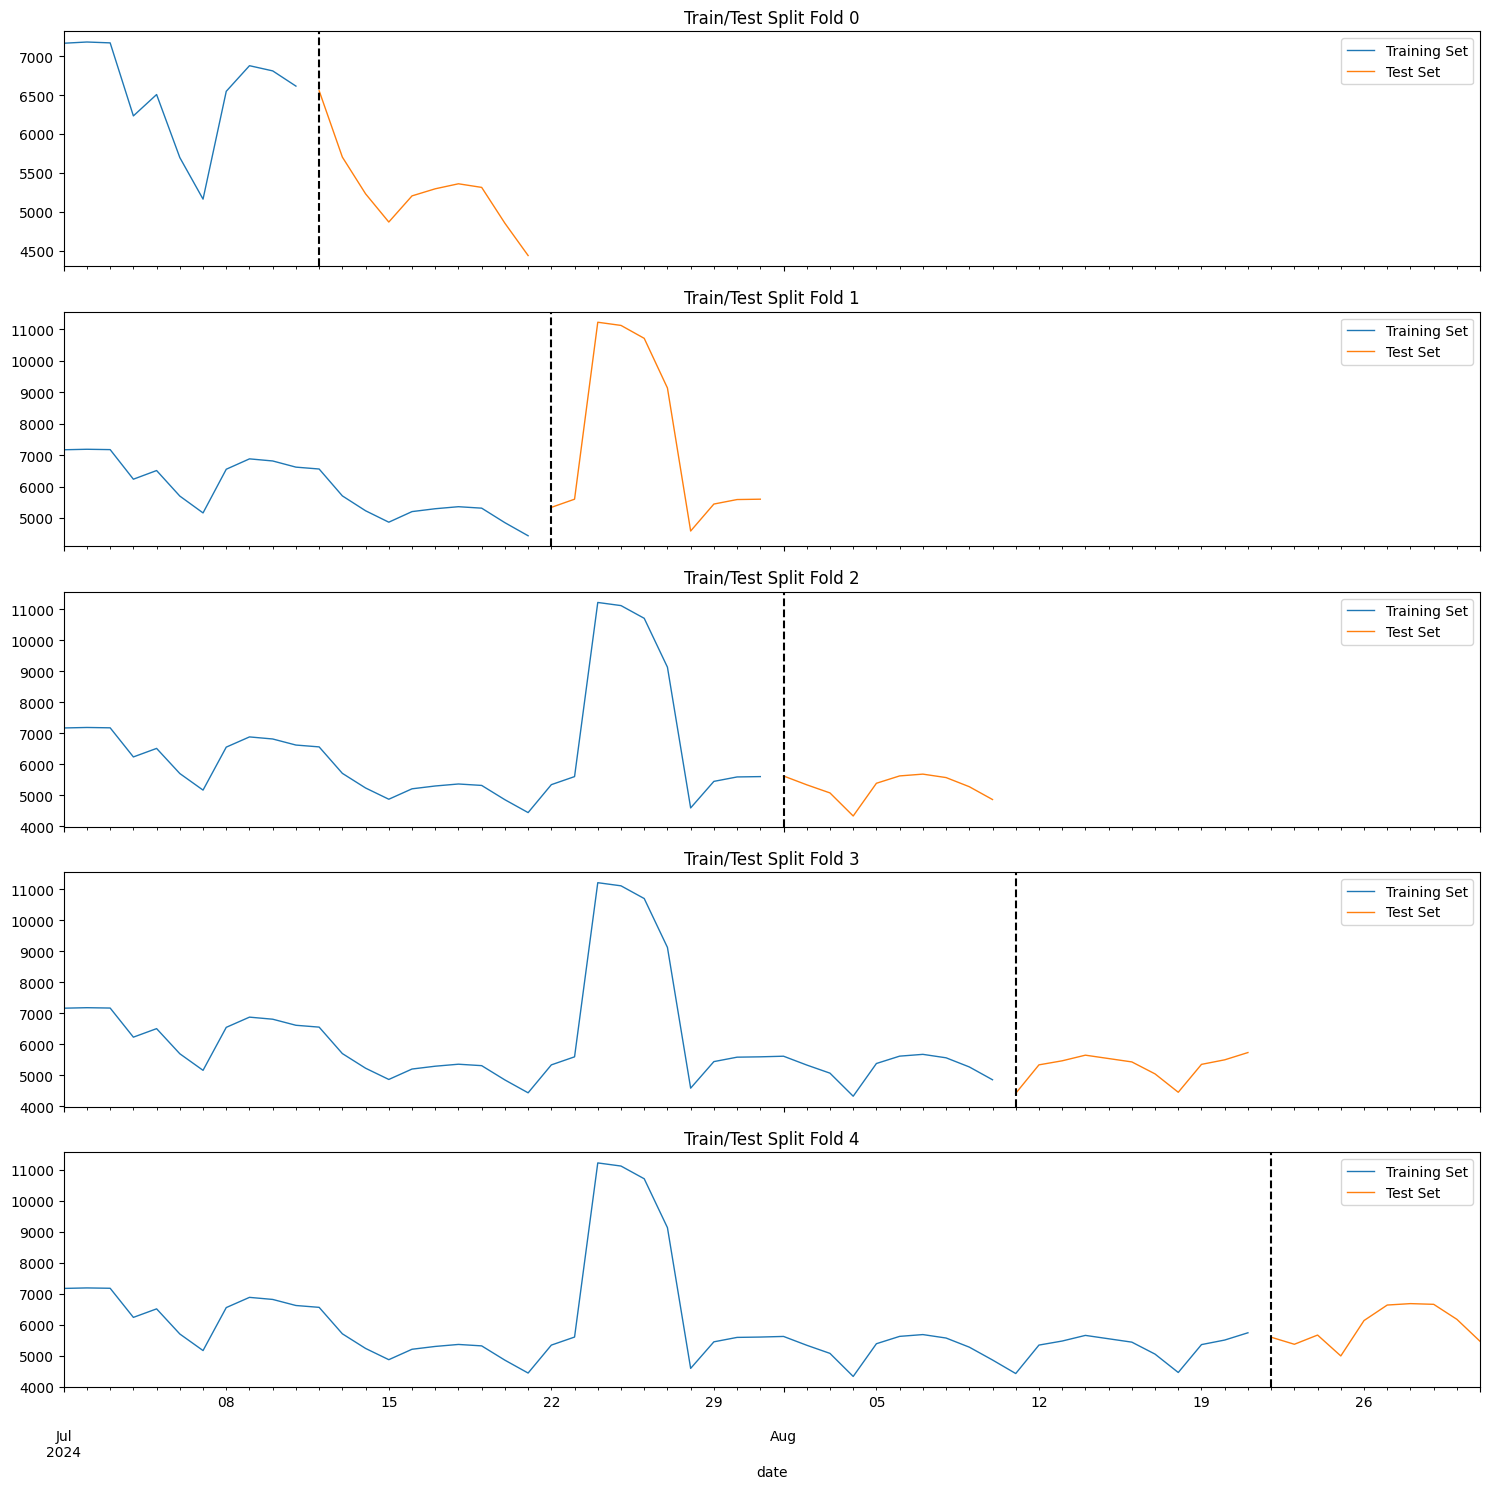

In [70]:
import matplotlib.pyplot as plt

# Set up subplots for each fold
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)  # Ensure number of subplots matches number of folds

fold = 0
for train_idx, val_idx in tscv.split(fc_clean):
    train = fc_clean.iloc[train_idx]
    test = fc_clean.iloc[val_idx]

    train['consumption'].plot(ax=axs[fold], lw=1,
                              label='Training Set',
                              title=f'Train/Test Split Fold {fold}')
    test['consumption'].plot(ax=axs[fold], lw=1,
                             label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    axs[fold].legend()  # Add legend for each subplot
    fold += 1

plt.tight_layout()
plt.show()

## Predicción del Futuro

Primero, se reentrena el modelo utilizando todos los datos disponibles. Esto permite aprovechar al máximo la información, ya que las predicciones se realizarán a partir de la última fecha registrada en el conjunto de datos:

In [71]:
#crear dataframe completo
fc_clean = create_attributes(fc_clean)

features = ['day','dayofweek','month','quarter','year','dayofyear']
target = ['consumption']

X_full = fc_clean[features]
y_full = fc_clean[target]

In [72]:
#crear instancia del regresor
xgb_regf = xgb.XGBRegressor(booster='gbtree',
                            seed=42,
                            n_estimators=1000,
                            early_stopping_rounds=50,
                            objective='reg:squarederror',
                            reg_lambda=0.001,
                            max_depth=5,
                            eta=0.01)
#entrenar modelo
xgb_regf.fit(X_full, y_full,
        eval_set=[(X_full, y_full)],
        verbose=100)

[0]	validation_0-rmse:1398.93073
[100]	validation_0-rmse:518.71458
[200]	validation_0-rmse:196.98125
[300]	validation_0-rmse:78.20273
[400]	validation_0-rmse:34.59726
[500]	validation_0-rmse:16.54902
[600]	validation_0-rmse:10.04966
[700]	validation_0-rmse:6.63475
[800]	validation_0-rmse:4.60504
[900]	validation_0-rmse:3.11770
[999]	validation_0-rmse:2.26770


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

### Resultados

- **Inicio del entrenamiento**: En la primera iteración (0), el RMSE es **1398.93**, indicando que el modelo aún no hace predicciones precisas.
- **Mejoras a través de las iteraciones**: A medida que avanza el entrenamiento, el RMSE disminuye notablemente:
  - En la iteración 100, el RMSE es **518.71**.
  - En la iteración 200, el RMSE se reduce a **196.98**.
  - En la iteración 300, llega a **78.20**.
- **Convergencia**: En las últimas iteraciones, el RMSE sigue disminuyendo, aunque más lentamente:
  - En la iteración 600, el RMSE es **10.05**.
  - Finalmente, en la iteración 999, el RMSE se estabiliza en **2.27**.

### Conclusiones

1. **Buen ajuste**: El modelo muestra una mejora continua en su capacidad predictiva.
2. **Detención anticipada**: Si se usó `early_stopping_rounds=50`, el entrenamiento podría haberse detenido antes de alcanzar la iteración 999.

A continuación, se crea un nuevo dataframe que incluye las fechas a pronosticar. Posteriormente, este dataframe se concatena con el dataframe original, añadiendo una columna booleana para identificar las fechas correspondientes al futuro.

En este caso, se pronostican 4 meses hacia adelante. Para generar el rango de fechas en la frecuencia deseada, se utiliza el método `date_range` de Pandas, configurado para obtener fechas diarias:

In [73]:
#rango de septiembre a diciembre 2024
pred_dates = pd.date_range('2024-09-01','2024-12-31', freq='D')
preds_df = pd.DataFrame(index=pred_dates)

#Crear columna
preds_df['Future'] = True
fc_clean['Future'] = False

#Concatenar dataframes
pred_fc = pd.concat([fc_clean.loc[fc_clean.index >= '01-01-2018'], preds_df])

Se agregan atributos mediante la función `create_attributes` y, finalmente, se genera un dataframe con las fechas futuras para realizar el pronóstico. El dataframe "futuro" se usará como entrada del modelo, mientras que el dataframe "completo" permitirá visualizar la serie de tiempo final:

In [74]:
#agregar atributos
pred_fc = pred_fc.copy()
pred_fc = create_attributes(pred_fc)

#seleccionar fechas
future_pred_fc = pred_fc.query('Future').copy()
future_pred_fc.head()

,consumption,day,dayofweek,month,quarter,year,dayofyear,Future
2024-09-01,NaN,1,6,9,3,2024,245,True
2024-09-02,NaN,2,0,9,3,2024,246,True
2024-09-03,NaN,3,1,9,3,2024,247,True
2024-09-04,NaN,4,2,9,3,2024,248,True
2024-09-05,NaN,5,3,9,3,2024,249,True


# Pronóstico

Se asignan los valores pronosticados a una nueva columna llamada `prediction`, y finalmente, se genera una gráfica que muestra tanto los datos históricos como el pronóstico obtenido.

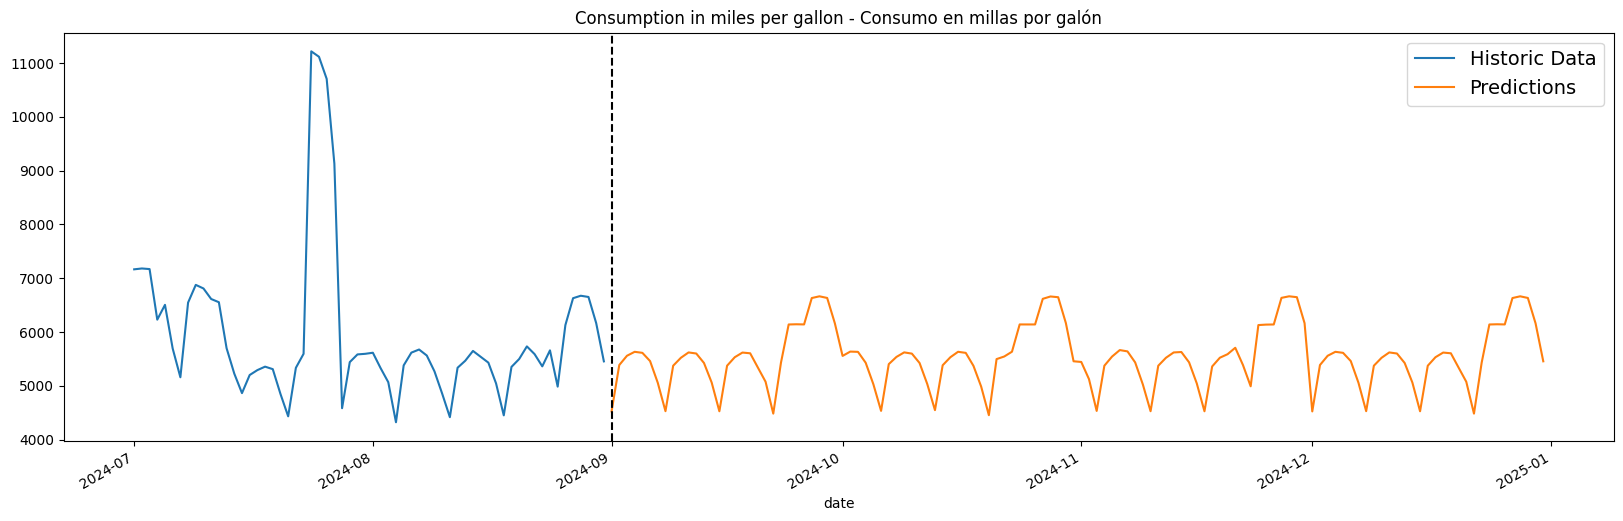

In [75]:
#predicciones del modelo
future_pred_fc['prediction'] = xgb_regf.predict(future_pred_fc[features])

#graficar
ax = fc_clean['consumption'].loc[fc_clean.index >= '01-01-2018']\
    .plot(figsize=(20, 6), lw=1.5, title='Consumption in miles per gallon - Consumo en millas por galón')
future_pred_fc['prediction'].plot(style='-', lw=1.5)
ax.axvline('2024-09-01', color='black', ls='--', lw=1.5)
plt.legend(['Historic Data','Predictions'], fontsize=14)
plt.show()